In [30]:
import argparse
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path as osp
import pickle
from tqdm import tqdm
import random
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns

# plt.rcParams['font.family'] = 'Times New Roman'


In [31]:
def get_recurrence_quantification(src, istime=False, min_ts=None, step=None, recur_matrix=None, color_dict=None):
    neighs, ts, eid  = ext_full_indices[src], ext_full_ts[src], ext_full_eid[src]
    intervals = []
    if not istime:
        recur_matrix = np.zeros((len(neighs), len(neighs)))
    else:
        pass
    for i in range(len(neighs)):
        for j in range(i+1, len(neighs)):
            if (neighs[j] == neighs[i]):
                idxi, idxj = (i, j) if not istime else (int((ts[i] - min_ts) // step), int((ts[j] - min_ts) // step))
                try:
                    recur_matrix[idxi][idxj] += 1
                except IndexError:
                    import pdb; pdb.set_trace()
    if not istime:
        return recur_matrix, np.sum(recur_matrix)

def tsort_original(i, indices, ts, eid):
    if not len(indices):
        return
    try:
        sidx = np.argsort(ts)
        indices = np.array(indices)[sidx]
        ts = np.array(ts)[sidx]
        eid = np.array(eid)[sidx]
    except TypeError:
        import pdb; pdb.set_trace()


In [32]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, help='dataset name')
parser.add_argument('--all_data', action='store_true')
parser.add_argument('--add_reverse', default=False, action='store_true')
parser.add_argument('--bins', type=int, default=-1)
parser.add_argument('--fontsize', type=int, default=10, help='font size')
parser.add_argument('--file_path', type=str, default='')
args = parser.parse_args(args=['--all_data', '--bins', '1000'])
plt.rcParams['font.size'] = args.fontsize
print(args)

# datasets = ['WIKI', 'REDDIT', 'Flights', 'LASTFM', 'mooc', 'uci', 'CollegeMsg']
# show_datasets = {
#     'WIKI': 'Wikipedia',
#     'REDDIT': 'REDDIT',
#     'Flights': 'Flights',
#     'LASTFM': 'LASTFM',
#     'mooc': 'MOOC',
#     'uci': 'UCI',
#     'CollegeMsg': 'CollegeMsg',
#     'syn1': 'SYN_1'
# }
# if not args.all_data:
#     assert args.data in datasets
#     datasets = [args.data,]
# else:
#     datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'syn1']
datasets = []
# for alpha in [0.9, 0.8, 0.7, 0.6, 0.5]:
for alpha in [0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1]:
    for beta in [0.4, 0.5, 0.6, 0.7, 0.8]:
        datasets.append(f"syn_{alpha}_{beta}")

total_matrices = []

Namespace(data=None, all_data=True, add_reverse=False, bins=1000, fontsize=14, file_path='')


In [33]:
# def norm_mat(recur_matrix):
#     ma, mi, me = np.max(recur_matrix[recur_matrix > 1e-6]), np.min(recur_matrix[recur_matrix > 1e-6]), np.mean(recur_matrix[recur_matrix > 1e-6])
#     p5 = np.percentile(recur_matrix[recur_matrix > 1e-6], 5)
#     p95 = np.percentile(recur_matrix[recur_matrix > 1e-6], 95)
#     # print(ma, mi, me, p5, p95)
#     recur_matrix[(recur_matrix > p95)] = p95 - 0.1
#     recur_matrix[(recur_matrix < p5) & (recur_matrix > 1e-6)] = p5 + 0.1
#     scalar = p95 - p5
#     return (recur_matrix - p5) / scalar

def norm_mat(recur_matrix):
    N = recur_matrix.shape[0]
    return (recur_matrix) / N / N


In [34]:
for data in datasets:
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    else:
        assert not args.all_data, 'Prepare data!'
        print('sorting and analyzing...')
        ext_full_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
        ext_full_indices = [[] for _ in range(num_nodes)]
        ext_full_ts = [[] for _ in range(num_nodes)]
        ext_full_eid = [[] for _ in range(num_nodes)]

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            src = int(row[s])
            dst = int(row[d])
            
            ext_full_indices[src].append(dst)
            ext_full_ts[src].append(row[t])
            ext_full_eid[src].append(idx)
            
            if args.add_reverse:
                ext_full_indices[dst].append(src)
                ext_full_ts[dst].append(row[t])
                ext_full_eid[dst].append(idx)

        for i in tqdm(range(num_nodes)):
            ext_full_indptr[i + 1] = ext_full_indptr[i] + len(ext_full_indices[i])
        tmp = np.array(list(itertools.chain(*ext_full_ts)))
        min_ts = np.min(tmp)
        max_ts = np.max(tmp)
        print(f'Bins: {BINS}\t Time span: {min_ts} - {max_ts}')
        time_bins, step = np.linspace(min_ts, max_ts, BINS+1, retstep=True)
        recur_matrices = []
        color_dict = {}
        recur_matrix = np.zeros((BINS+1, BINS+1))
        for i in tqdm(range(num_nodes)):
            tsort_original(i, ext_full_indices[i], ext_full_ts[i], ext_full_eid[i])
            get_recurrence_quantification(i, True, min_ts, step, recur_matrix, color_dict)
        with open(args.file_path, 'wb') as f:
            all_data = {
                'indptr': ext_full_indptr,
                'indices': ext_full_indices,
                'ts': ext_full_ts,
                'eid': ext_full_eid,
                'recur': recur_matrix,
                'min_ts': min_ts,
                'step': step
            }
            pickle.dump(all_data, f)

    total_matrix = recur_matrix

    # ma, mi, me = np.max(total_matrix[total_matrix > 1e-6]), np.min(total_matrix[total_matrix > 1e-6]), np.mean(total_matrix[total_matrix > 1e-6])
    # p5 = np.percentile(total_matrix[total_matrix > 1e-6], 5)
    # p95 = np.percentile(total_matrix[total_matrix > 1e-6], 95)
    # print(ma, mi, me, p5, p95)
    # scalar = p95 - p5

    # total_matrix[(total_matrix > p95)] = p95 - 0.1
    # total_matrix[(total_matrix < p5) & (total_matrix > 1e-6)] = p5 + 0.1

    total_matrices.append(total_matrix)


num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10001
loading...
num_nodes:  10

Plotting heatmap...


/tmp/ipykernel_3159506/2571677647.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont:

Saving...


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

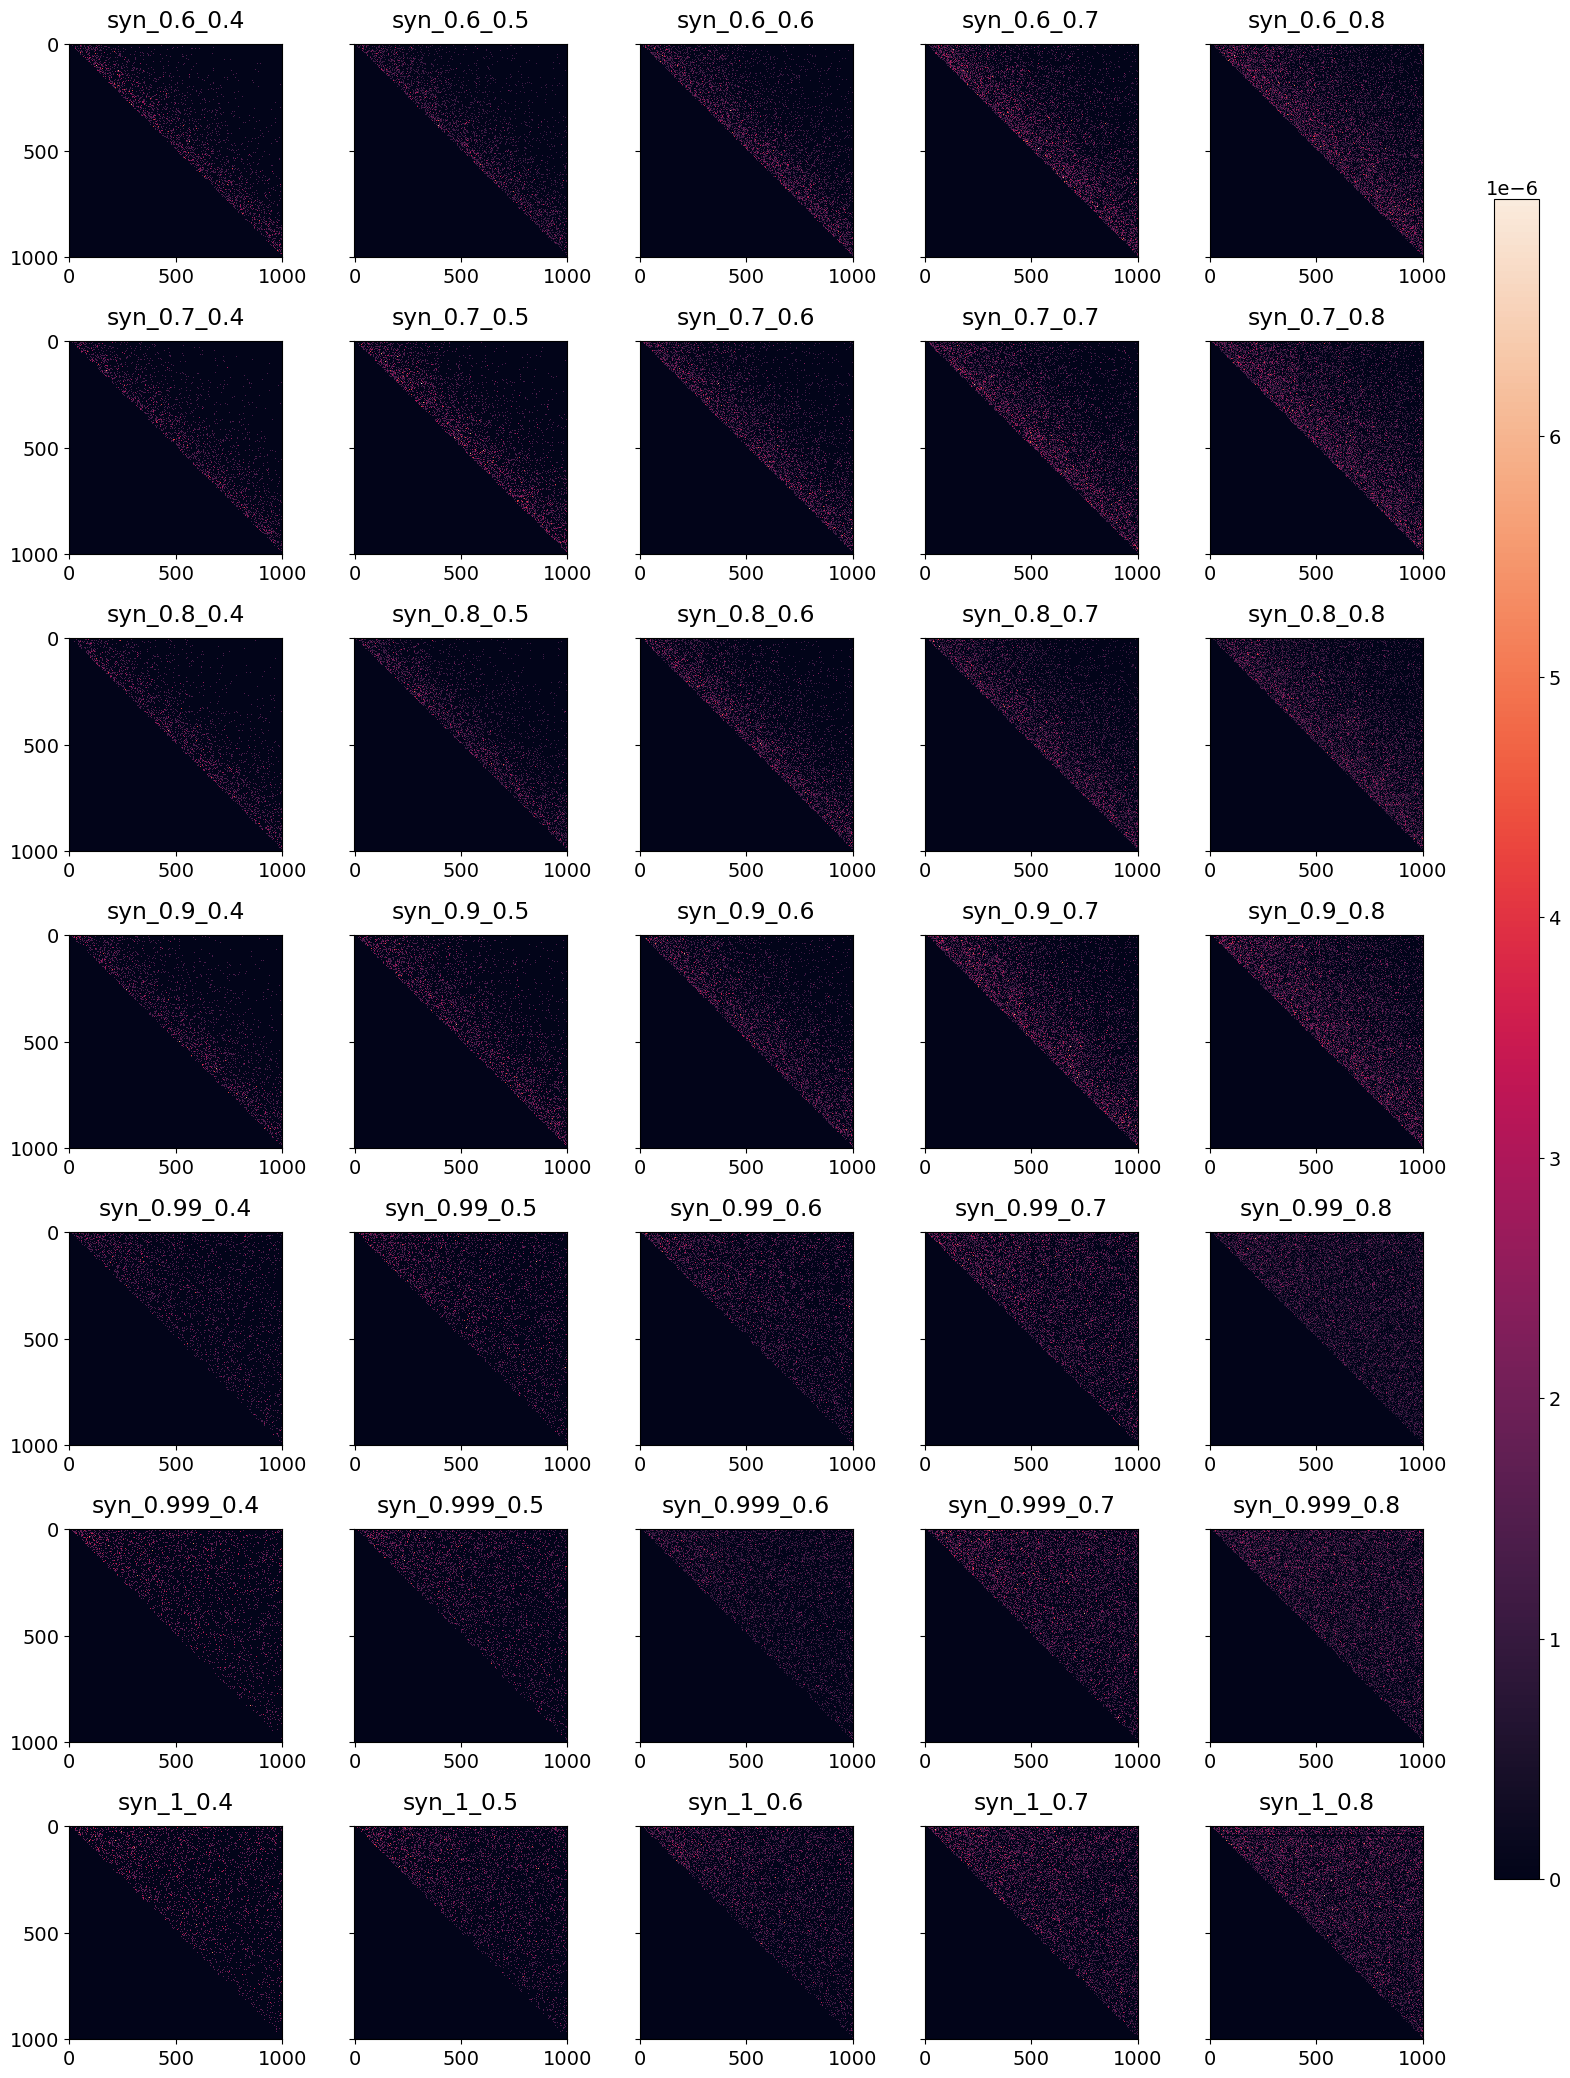

In [44]:
plt.rcParams['font.size'] = args.fontsize
fig, axes = plt.subplots(len(datasets)//5, 5, sharex=True, sharey=True, figsize=(15, 3*len(datasets)//5))
cbar_ax = fig.add_axes([1.01, .1, .03, .8])
print('Plotting heatmap...')
for i, ax in enumerate(axes.flat):
    # sns.heatmap(total_matrices[i], vmin=0, vmax=1, ax=ax, cbar=(i==0), xticklabels=int(BINS/5), 
    #             yticklabels=int(BINS/5),square=True, cbar_ax=None if i else cbar_ax)
    im = ax.matshow(total_matrices[i], cmap='rocket',)
    ax.set_xticks(np.arange(0, BINS+1, BINS//2))
    ax.set_yticks(np.arange(0, BINS+1, BINS//2))
    ax.set_title(f'{datasets[i]}', y=1.04)
    ax.xaxis.set_ticks_position('bottom')
fig.colorbar(im, cax=cbar_ax,)
print('Saving...')
fig.tight_layout()
plt.savefig(f'../figures/recurrence/all_recurrence_analysis.pdf',bbox_inches='tight')

In [36]:
def time_density(recur_matrix, alpha, l):
    denom = 0.
    numer = 0.
    N = recur_matrix.shape[0]
    for i in range(l):
        for j in range(l):
            denom += recur_matrix[i, j]
            numer += recur_matrix[i, j] * (alpha ** i)
    return numer/denom

In [37]:
TDs = {}
# datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']


for data in datasets:
    TDs[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            # recur_matrix = norm_mat(all_data['recur'])
            recur_matrix = all_data['recur']
            min_ts, step = all_data['min_ts'], all_data['step']
    
    for alpha in np.arange(0.9, 1,0.1):
        TDs[data].append(time_density(recur_matrix, alpha, 500))
    print(data, TDs[data])


num_nodes:  10001
loading...
syn_0.6_0.4 [0.030363124197910193]
num_nodes:  10001
loading...
syn_0.6_0.5 [0.03027604519472441]
num_nodes:  10001
loading...
syn_0.6_0.6 [0.0331181282037043]
num_nodes:  10001
loading...
syn_0.6_0.7 [0.032783595104259156]
num_nodes:  10001
loading...
syn_0.6_0.8 [0.0359351159222887]
num_nodes:  10001
loading...
syn_0.7_0.4 [0.030246962559196722]
num_nodes:  10001
loading...
syn_0.7_0.5 [0.03008596202735243]
num_nodes:  10001
loading...
syn_0.7_0.6 [0.03353173189757604]
num_nodes:  10001
loading...
syn_0.7_0.7 [0.034477059119978726]
num_nodes:  10001
loading...
syn_0.7_0.8 [0.036732606393985]
num_nodes:  10001
loading...
syn_0.8_0.4 [0.03168218944099093]
num_nodes:  10001
loading...
syn_0.8_0.5 [0.032715258095726577]
num_nodes:  10001
loading...
syn_0.8_0.6 [0.035011286057236794]
num_nodes:  10001
loading...
syn_0.8_0.7 [0.037302247809109644]
num_nodes:  10001
loading...
syn_0.8_0.8 [0.03737393847036936]
num_nodes:  10001
loading...
syn_0.9_0.4 [0.03476639

In [38]:
def RR(recur_matrix, tau):
    N = recur_matrix.shape[0]
    RRt = 0
    for i in range(N-tau):
        assert i >= 0 and i < N
        assert i+tau >= 0 and i+tau < N
        RRt += recur_matrix[i, i+tau]
    RRt /= (N-tau)
    return RRt


num_nodes:  10001
loading...
syn_0.6_0.4 1 4.2315327030611986e-07
syn_0.6_0.4 2 4.0759281518522457e-07
syn_0.6_0.4 3 4.270012818578508e-07
syn_0.6_0.4 4 4.5245471834930767e-07
syn_0.6_0.4 5 4.5892105639587287e-07
syn_0.6_0.4 6 4.343068314273011e-07
syn_0.6_0.4 7 3.98598782106624e-07
syn_0.6_0.4 8 4.2010599429012037e-07
syn_0.6_0.4 9 3.9537820305439956e-07
syn_0.6_0.4 10 4.5217290131810835e-07
syn_0.6_0.4 11 4.3549221643854536e-07
syn_0.6_0.4 12 4.04650355306375e-07
syn_0.6_0.4 13 4.0000929799390664e-07
syn_0.6_0.4 14 3.7816932168781143e-07
syn_0.6_0.4 15 3.653946060423983e-07
syn_0.6_0.4 16 3.840031832344107e-07
syn_0.6_0.4 17 4.107634282337647e-07
syn_0.6_0.4 18 3.8783025887478056e-07
syn_0.6_0.4 19 4.014370503278762e-07
syn_0.6_0.4 20 3.987942654780424e-07
syn_0.6_0.4 21 3.676317158753108e-07
syn_0.6_0.4 22 3.985895520305973e-07
syn_0.6_0.4 23 4.051198255766711e-07
syn_0.6_0.4 24 3.7693255427415066e-07
syn_0.6_0.4 25 3.834540199814286e-07
syn_0.6_0.4 26 3.736113779916149e-07
syn_0.6_

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

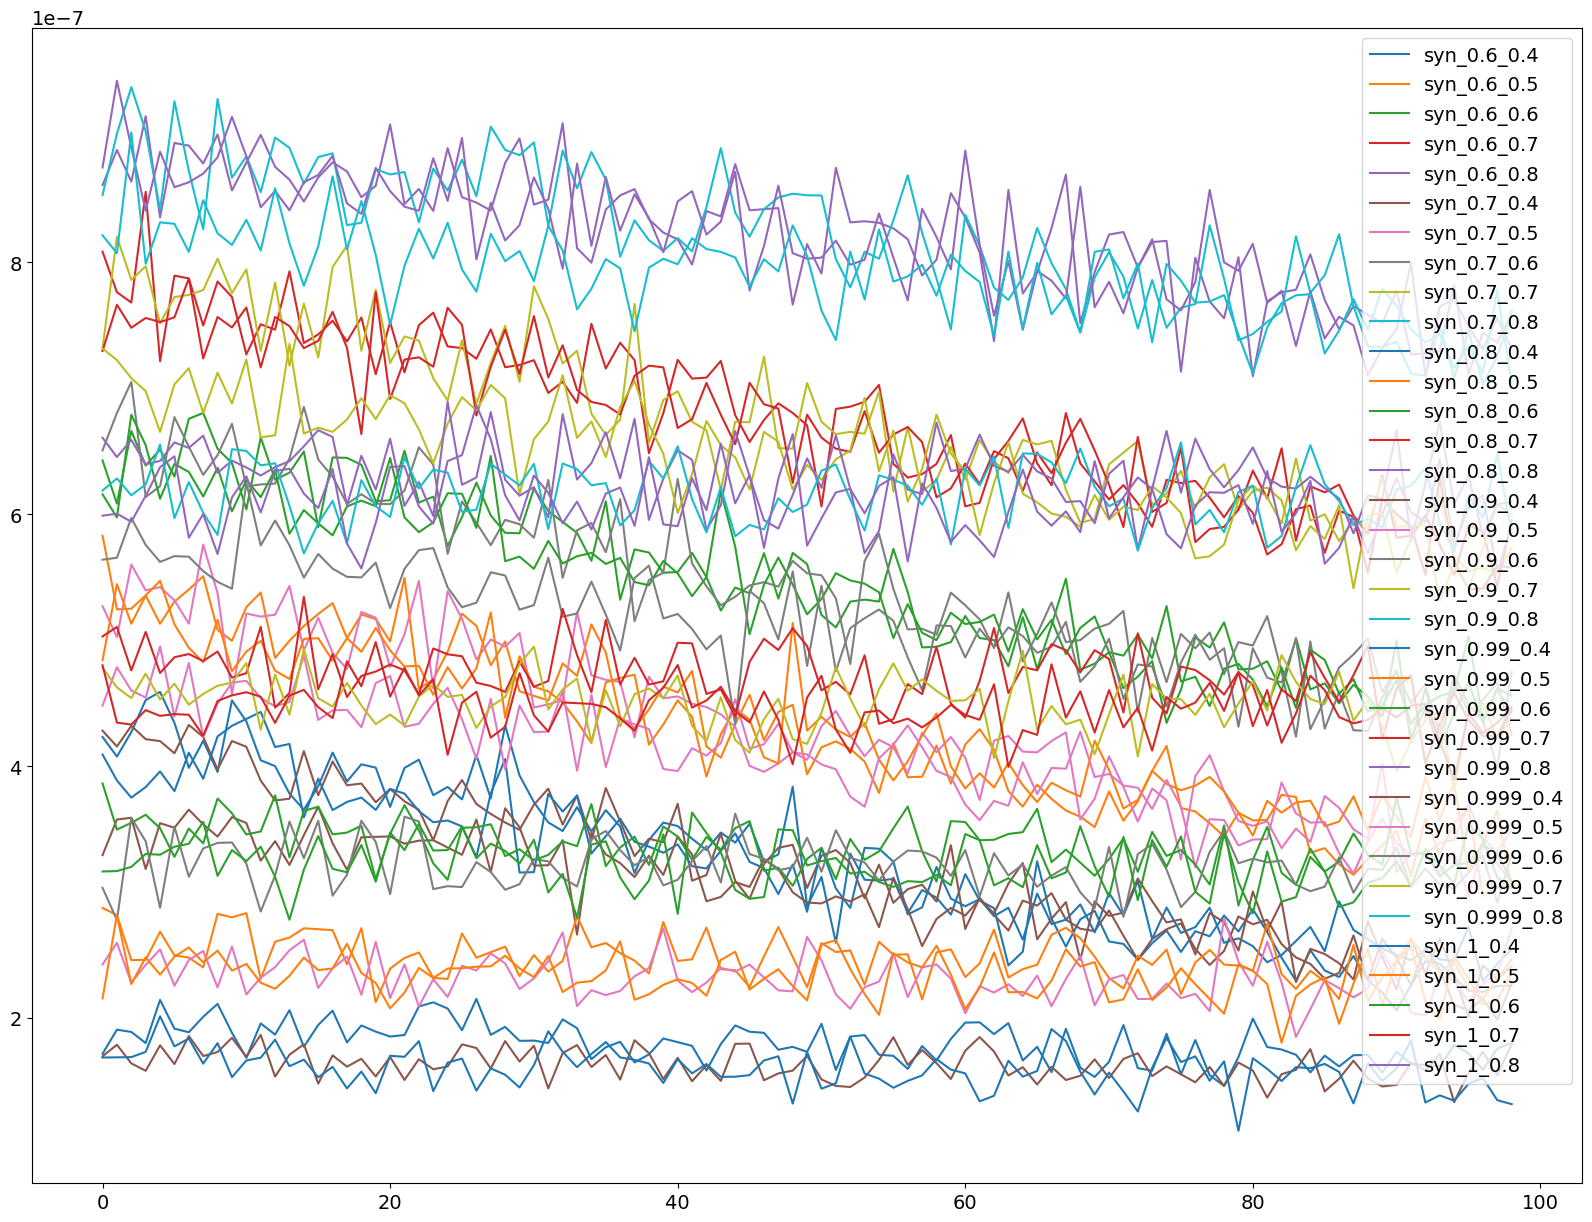

In [39]:
RRts = {}
# datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']


for data in datasets:
    RRts[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    for tau in range(1, 100):
        RRts[data].append(RR(recur_matrix, tau))
        print(data, tau, RRts[data][-1])
# fig, axes = plt.subplots( len(datasets)//2,2, sharex=True, figsize=(15, 7.5*len(datasets)//2))
fig, axes = plt.subplots(figsize=(20, 15))
print('Plotting RR...')
# for i, ax in enumerate(axes.flat):
xs = range(len(datasets[i]))
for ax in [axes]:
    for i, dataset in enumerate(datasets):
        ax.plot( RRts[datasets[i]], label=f'{datasets[i]}')
    # ax.set_title(, y=1.04)
ax.legend()

In [40]:
def TREND(RRt, N_tilde):
    RRt_mean = np.mean(RRt[:N_tilde])
    denom = np.sum([(tau - N_tilde)**2 for tau in range(N_tilde)])
    numer = np.sum([(tau - N_tilde)*(RRt[tau] - RRt_mean) for tau in range(N_tilde)])
    return numer/denom


In [41]:
RRt = [0.9, 0.5, 0.2, 0.1, 0.01]
# RRt = [0.9, 0.8, 0.5, 0.2, 0.1]
N = 5
print(TREND(RRt, N))
RRt = [0.9, 0.8, 0.7, 0.7, 0.7]
N = 5
print(TREND(RRt, N))

-0.03963636363636365
-0.00909090909090906


In [42]:
TRENDs = {}
N_tilde = 950
for i, data in enumerate(datasets):
    TRENDs[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    TRENDs[data]= TREND(RRts[data], N_tilde)
    print(data, TRENDs[data])
# fig, axes = plt.subplots(2, len(datasets)//2, sharex=True, figsize=(15, 15))
# print('Plotting TREND...')
# for i, ax in enumerate(axes.flat):
#     ax.plot(TRENDs[datasets[i]])

num_nodes:  10001
loading...


IndexError: list index out of range

In [ ]:
def P(recur_matrix, l, N_tilde):
    P = 0.0
    for i in range(1, N_tilde-l):
        for j in range(1, N_tilde-l):
            r = 1.0
            for k in range(l):
                r *= recur_matrix[i+k, j+k]
            P += r * (1-recur_matrix[i, j]) * (1-recur_matrix[i+l-1, j+l-1])
    return P 

def DETt(recur_matrix, lmin, tau):
    N = recur_matrix.shape[0]
    Pt = 0
    for i in range(N-tau):
        assert i >= 0 and i < N
        assert i+tau >= 0 and i+tau < N
        Pt += recur_matrix[i, i+tau]
    Pt /= (N-tau)
    return RRt

In [ ]:
for i, data in enumerate(datasets):
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    N_tilde = 100
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            N = recur_matrix.shape[0]
            min_ts, step = all_data['min_ts'], all_data['step']
        DET = np.sum([l * P(recur_matrix, l, N_tilde) for l in range(30, N_tilde)]) / np.sum([l * P(recur_matrix, l, N_tilde) for l in range(N_tilde)])
        print(data, DET)

num_nodes:  9228
loading...
WIKI -6.944325829871986e-05
num_nodes:  1900
loading...
uci 2.1890988399038424e-20
num_nodes:  10985
loading...
REDDIT -0.06283950484765422
num_nodes:  13170
loading...
Flights -29.988945020299457
num_nodes:  1980
loading...
LASTFM 5.245832631394812e-09
num_nodes:  7047
loading...
mooc 0.0002019714305201565
